# Module 6: Measuring Speedup in Distributed Systems

**DSC 232R - Big Data Analysis Using Spark**

This notebook covers:
1. Why measuring speedup matters
2. Speedup and efficiency formulas
3. Practical measurement techniques in Spark
4. Estimating parallelizable fraction from measurements
5. Visualizing and reporting your results

## Key Takeaways

- **Speedup** measures how much faster parallel execution is compared to sequential
- **Efficiency** tells you how well you're utilizing your parallel resources
- **Practical measurement** validates theoretical expectations (Amdahl's Law)
- **Bottleneck identification** helps optimize your distributed applications

---

## 1. Why Measure Speedup?

### Theory vs Reality

In Module 1, you learned about Amdahl's Law:

$$S(n) = \frac{1}{(1-p) + \frac{p}{n}}$$

But theoretical speedup assumes:
- Perfect parallelization of the parallel portion
- Zero communication overhead
- No resource contention

**Real-world speedup is always lower.** Measuring it tells you:
1. How efficient your implementation actually is
2. Where bottlenecks exist
3. Whether adding more resources will help

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from contextlib import contextmanager

%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')

print("Libraries loaded successfully")

Libraries loaded successfully


---

## 2. Speedup and Efficiency Formulas

### Speedup

$$\text{Speedup}(n) = \frac{T_1}{T_n}$$

Where:
- $T_1$ = Execution time with 1 executor/worker
- $T_n$ = Execution time with n executors/workers

### Efficiency

$$\text{Efficiency}(n) = \frac{\text{Speedup}(n)}{n} = \frac{T_1}{n \times T_n}$$

### Interpretation

| Efficiency | Meaning |
|------------|--------|
| 100% | Perfect parallelization (theoretical ideal) |
| 70-90% | Good parallelization |
| 50-70% | Acceptable, room for improvement |
| < 50% | Significant overhead or bottlenecks |

In [2]:
def calculate_speedup(T_1, T_n):
    """Calculate speedup from timing measurements."""
    return T_1 / T_n

def calculate_efficiency(speedup, n_workers):
    """Calculate efficiency from speedup and worker count."""
    return speedup / n_workers

def amdahl_speedup(p, n):
    """Calculate theoretical speedup using Amdahl's Law.

    Args:
        p: Parallelizable fraction (0 to 1)
        n: Number of processors/workers
    """
    return 1 / ((1 - p) + p / n)

# Example calculation
T_1 = 120.0  # 120 seconds with 1 executor
T_7 = 25.0   # 25 seconds with 7 executors
n = 7

speedup = calculate_speedup(T_1, T_7)
efficiency = calculate_efficiency(speedup, n)

print(f"Example Measurement")
print(f"="*40)
print(f"T_1 (1 executor):  {T_1:.1f} seconds")
print(f"T_7 (7 executors): {T_7:.1f} seconds")
print(f"")
print(f"Speedup:    {speedup:.2f}x")
print(f"Efficiency: {efficiency:.1%}")

Example Measurement
T_1 (1 executor):  120.0 seconds
T_7 (7 executors): 25.0 seconds

Speedup:    4.80x
Efficiency: 68.6%


---

## 3. Timing Your Code

### Creating a Timing Context Manager

A context manager makes it easy to time code blocks consistently:

In [3]:
@contextmanager
def timer(description: str):
    """Context manager for timing code blocks.

    Usage:
        with timer("My operation"):
            # code to time
    """
    start = time.time()
    yield
    elapsed = time.time() - start
    print(f"{description}: {elapsed:.2f} seconds")

# Demonstration
with timer("Sleep for 0.5 seconds"):
    time.sleep(0.5)

Sleep for 0.5 seconds: 0.50 seconds


In [4]:
# More detailed timer that returns the elapsed time
class Timer:
    """Timer class for collecting timing measurements."""

    def __init__(self, description: str = ""):
        self.description = description
        self.elapsed = 0

    def __enter__(self):
        self.start = time.time()
        return self

    def __exit__(self, *args):
        self.elapsed = time.time() - self.start
        if self.description:
            print(f"{self.description}: {self.elapsed:.2f}s")

# Example: collect timing for later analysis
timings = []

for i in range(3):
    with Timer(f"Run {i+1}") as t:
        time.sleep(0.1 + 0.05 * i)  # Varying sleep times
    timings.append(t.elapsed)

print(f"\nCollected timings: {timings}")
print(f"Average: {np.mean(timings):.3f}s")

Run 1: 0.10s
Run 2: 0.15s
Run 3: 0.20s

Collected timings: [0.10010027885437012, 0.15076184272766113, 0.20085835456848145]
Average: 0.151s


---

## 4. Simulating Speedup Measurements

Let's simulate what speedup measurements look like in practice.

We'll model a workload with:
- A serial component (data loading, result aggregation)
- A parallel component (the actual computation)
- Communication overhead (grows with workers)

In [5]:
def simulate_distributed_execution(n_workers, parallel_fraction=0.9,
                                    base_work=100.0, overhead_per_worker=0.5):
    """
    Simulate execution time for a distributed workload.

    Args:
        n_workers: Number of parallel workers
        parallel_fraction: Fraction of work that can be parallelized (p)
        base_work: Total work units in serial execution
        overhead_per_worker: Communication/coordination overhead per worker

    Returns:
        Simulated execution time
    """
    serial_time = base_work * (1 - parallel_fraction)
    parallel_time = base_work * parallel_fraction / n_workers
    overhead = overhead_per_worker * np.sqrt(n_workers)  # Overhead grows sub-linearly

    return serial_time + parallel_time + overhead

# Simulate measurements
worker_counts = [1, 2, 3, 4, 5, 7, 10, 15]
parallel_fraction = 0.85

times = [simulate_distributed_execution(n, parallel_fraction) for n in worker_counts]
T_1 = times[0]

# Calculate speedup and efficiency
speedups = [T_1 / t for t in times]
efficiencies = [s / n for s, n in zip(speedups, worker_counts)]

# Display results
print(f"Simulated Speedup Analysis (p = {parallel_fraction:.0%})")
print("=" * 55)
print(f"{'Workers':>8} {'Time':>10} {'Speedup':>10} {'Efficiency':>12}")
print("-" * 55)
for n, t, s, e in zip(worker_counts, times, speedups, efficiencies):
    print(f"{n:>8} {t:>10.2f} {s:>10.2f}x {e:>11.1%}")

Simulated Speedup Analysis (p = 85%)
 Workers       Time    Speedup   Efficiency
-------------------------------------------------------
       1     100.50       1.00x      100.0%
       2      58.21       1.73x       86.3%
       3      44.20       2.27x       75.8%
       4      37.25       2.70x       67.4%
       5      33.12       3.03x       60.7%
       7      28.47       3.53x       50.4%
      10      25.08       4.01x       40.1%
      15      22.60       4.45x       29.6%


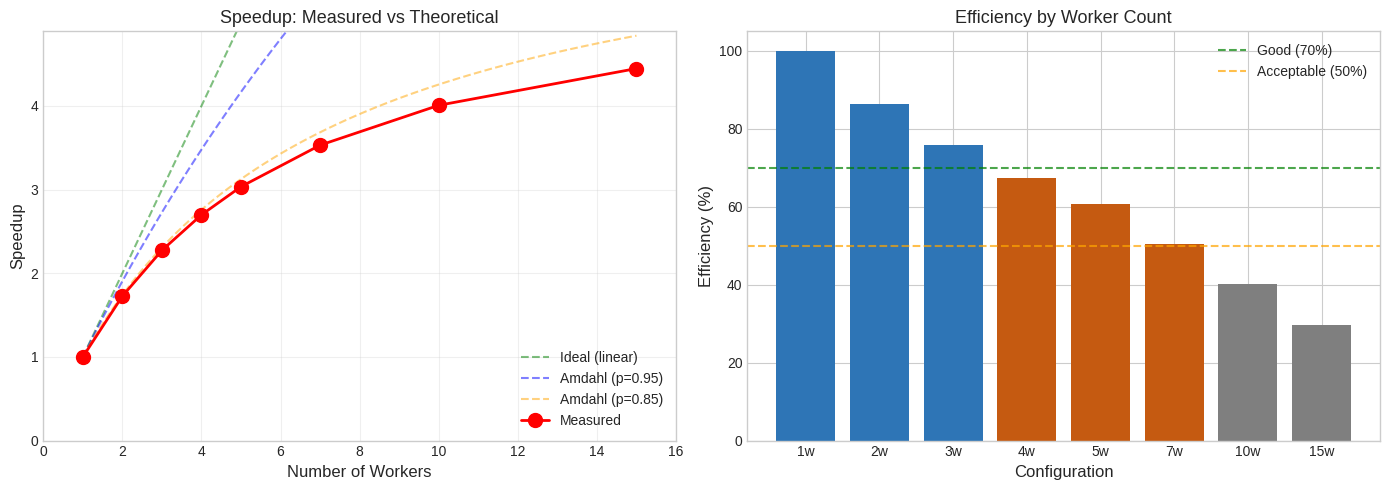

In [6]:
# Visualize the results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Speedup comparison
ax1 = axes[0]
n_range = np.linspace(1, max(worker_counts), 100)

# Theoretical curves
ideal = n_range
amdahl_85 = [amdahl_speedup(0.85, n) for n in n_range]
amdahl_95 = [amdahl_speedup(0.95, n) for n in n_range]

ax1.plot(n_range, ideal, 'g--', alpha=0.5, label='Ideal (linear)')
ax1.plot(n_range, amdahl_95, 'b--', alpha=0.5, label='Amdahl (p=0.95)')
ax1.plot(n_range, amdahl_85, 'orange', linestyle='--', alpha=0.5, label='Amdahl (p=0.85)')
ax1.plot(worker_counts, speedups, 'ro-', markersize=10, linewidth=2, label='Measured')

ax1.set_xlabel('Number of Workers', fontsize=12)
ax1.set_ylabel('Speedup', fontsize=12)
ax1.set_title('Speedup: Measured vs Theoretical', fontsize=13)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0, max(worker_counts) + 1)
ax1.set_ylim(0, max(speedups) * 1.1)

# Plot 2: Efficiency
ax2 = axes[1]
ax2.bar(range(len(worker_counts)), [e * 100 for e in efficiencies],
        color=['#2E75B6' if e > 0.7 else '#C55A11' if e > 0.5 else '#7F7F7F'
               for e in efficiencies])
ax2.axhline(y=70, color='green', linestyle='--', alpha=0.7, label='Good (70%)')
ax2.axhline(y=50, color='orange', linestyle='--', alpha=0.7, label='Acceptable (50%)')

ax2.set_xlabel('Configuration', fontsize=12)
ax2.set_ylabel('Efficiency (%)', fontsize=12)
ax2.set_title('Efficiency by Worker Count', fontsize=13)
ax2.set_xticks(range(len(worker_counts)))
ax2.set_xticklabels([f'{n}w' for n in worker_counts])
ax2.legend(fontsize=10)
ax2.set_ylim(0, 105)

plt.tight_layout()
plt.show()

---

## 5. Estimating Parallelizable Fraction

From your measurements, you can estimate what fraction of your code is actually parallelizable.

### Rearranging Amdahl's Law

$$p = \frac{n \times (S - 1)}{S \times (n - 1)}$$

Where:
- $p$ = parallelizable fraction
- $S$ = measured speedup
- $n$ = number of workers

In [7]:
def estimate_parallel_fraction(speedup, n_workers):
    """
    Estimate parallelizable fraction from measured speedup.

    Derived by rearranging Amdahl's Law:
    S = 1 / ((1-p) + p/n)

    Solving for p:
    p = n(S-1) / (S(n-1))
    """
    if n_workers <= 1:
        return 1.0  # Can't estimate from single worker

    S = speedup
    n = n_workers
    p = (n * (S - 1)) / (S * (n - 1))

    # Clamp to valid range [0, 1]
    return max(0, min(1, p))

# Estimate from our simulated measurements
print("Estimating Parallelizable Fraction")
print("=" * 50)
print(f"{'Workers':>8} {'Speedup':>10} {'Est. p':>10}")
print("-" * 50)

for n, s in zip(worker_counts[1:], speedups[1:]):  # Skip n=1
    p_est = estimate_parallel_fraction(s, n)
    print(f"{n:>8} {s:>10.2f}x {p_est:>9.1%}")

# Average estimate
p_estimates = [estimate_parallel_fraction(s, n) for n, s in zip(worker_counts[1:], speedups[1:])]
print(f"\nAverage estimated p: {np.mean(p_estimates):.1%}")
print(f"(Actual p used in simulation: {parallel_fraction:.0%})")

Estimating Parallelizable Fraction
 Workers    Speedup     Est. p
--------------------------------------------------
       2       1.73x     84.2%
       3       2.27x     84.0%
       4       2.70x     83.9%
       5       3.03x     83.8%
       7       3.53x     83.6%
      10       4.01x     83.4%
      15       4.45x     83.0%

Average estimated p: 83.7%
(Actual p used in simulation: 85%)


### Why the Estimate May Differ

The estimated p is often lower than theoretical because:
1. **Communication overhead** - not accounted for in Amdahl's Law
2. **Resource contention** - workers compete for shared resources
3. **Load imbalance** - some workers finish early and wait

This is useful information! A large gap between theoretical and estimated p indicates optimization opportunities.

---

## 6. Creating a Results Table for Your Project

For Milestone 3, you need to document your speedup analysis. Here's how to create a professional results table:

In [8]:
import pandas as pd

def create_speedup_table(measurements):
    """
    Create a formatted speedup analysis table.

    Args:
        measurements: List of tuples (n_workers, execution_time)

    Returns:
        pandas DataFrame with speedup analysis
    """
    T_1 = measurements[0][1]  # Baseline time

    data = []
    for n_workers, exec_time in measurements:
        speedup = T_1 / exec_time
        efficiency = speedup / n_workers

        data.append({
            'Executors': n_workers,
            'Time (sec)': f'{exec_time:.1f}',
            'Speedup': f'{speedup:.2f}x',
            'Efficiency': f'{efficiency:.0%}'
        })

    return pd.DataFrame(data)

# Example measurements (as you would record from Spark)
example_measurements = [
    (1, 120.0),   # Baseline
    (3, 48.5),    # 3 executors
    (5, 32.1),    # 5 executors
    (7, 25.0),    # 7 executors
]

table = create_speedup_table(example_measurements)
print("Speedup Analysis Table")
print("=" * 50)
print(table.to_string(index=False))

Speedup Analysis Table
 Executors Time (sec) Speedup Efficiency
         1      120.0   1.00x       100%
         3       48.5   2.47x        82%
         5       32.1   3.74x        75%
         7       25.0   4.80x        69%


In [9]:
# Generate markdown for your README
def generate_markdown_table(measurements):
    """Generate markdown table for README.md."""
    T_1 = measurements[0][1]

    lines = [
        "| Executors | Time (sec) | Speedup | Efficiency |",
        "|-----------|------------|---------|------------|"
    ]

    for n, t in measurements:
        s = T_1 / t
        e = s / n
        lines.append(f"| {n} | {t:.1f} | {s:.2f}x | {e:.0%} |")

    return "\n".join(lines)

print("Copy this to your README.md:")
print()
print("## Speedup Analysis")
print()
print(generate_markdown_table(example_measurements))

Copy this to your README.md:

## Speedup Analysis

| Executors | Time (sec) | Speedup | Efficiency |
|-----------|------------|---------|------------|
| 1 | 120.0 | 1.00x | 100% |
| 3 | 48.5 | 2.47x | 82% |
| 5 | 32.1 | 3.74x | 75% |
| 7 | 25.0 | 4.80x | 69% |


---

## 7. Exercise: Analyze Your Own Data

### Exercise 1: Calculate Speedup and Efficiency

Given these measurements from a Spark job, calculate speedup and efficiency:

In [10]:
# Exercise 1: Your measurements
your_measurements = [
    # (n_executors, time_seconds)
    (1, 342.0),
    (4, 98.0),
    (7, 62.0),
    (15, 48.0),
]

# TODO: Calculate speedup and efficiency for each configuration
# Hint: T_1 = your_measurements[0][1]

# YOUR CODE HERE
T_1 = None  # Fill in

print("Your Speedup Analysis")
print("=" * 50)
# Print your results

Your Speedup Analysis


In [11]:
# Solution
your_measurements = [
    (1, 342.0),
    (4, 98.0),
    (7, 62.0),
    (15, 48.0),
]

T_1 = your_measurements[0][1]

print("Solution: Speedup Analysis")
print("=" * 55)
print(f"{'Executors':>10} {'Time':>10} {'Speedup':>10} {'Efficiency':>12}")
print("-" * 55)

for n, t in your_measurements:
    speedup = T_1 / t
    efficiency = speedup / n
    print(f"{n:>10} {t:>10.1f}s {speedup:>10.2f}x {efficiency:>11.0%}")

# Estimate parallelizable fraction using 7 executors
s_7 = T_1 / 62.0
p_est = estimate_parallel_fraction(s_7, 7)
print(f"\nEstimated parallelizable fraction (from 7 executors): {p_est:.1%}")

Solution: Speedup Analysis
 Executors       Time    Speedup   Efficiency
-------------------------------------------------------
         1      342.0s       1.00x        100%
         4       98.0s       3.49x         87%
         7       62.0s       5.52x         79%
        15       48.0s       7.12x         48%

Estimated parallelizable fraction (from 7 executors): 95.5%


### Exercise 2: Create a Speedup Visualization

Create a plot comparing your measured speedup to the theoretical maximum:

In [12]:
# Exercise 2: Create a speedup plot

# Your measurements
executors = [1, 4, 7, 15]
times = [342.0, 98.0, 62.0, 48.0]

# TODO:
# 1. Calculate speedups
# 2. Create theoretical curves (ideal and Amdahl with estimated p)
# 3. Plot measured vs theoretical
# 4. Add labels and legend

# YOUR CODE HERE
# plt.figure(figsize=(10, 6))
# ...

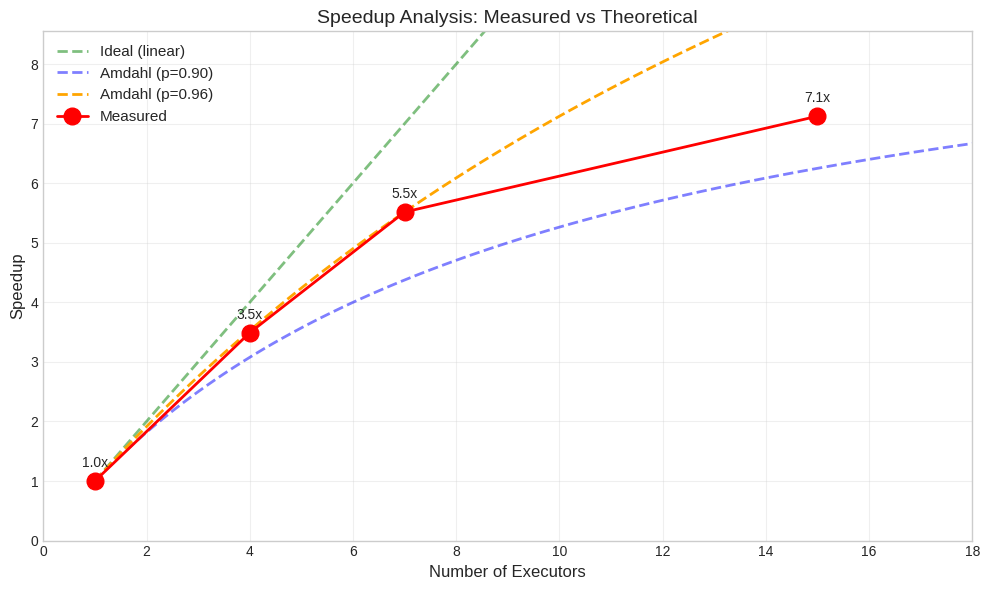


Plot saved as 'speedup_analysis.png'


In [13]:
# Solution
executors = [1, 4, 7, 15]
times = [342.0, 98.0, 62.0, 48.0]
speedups_measured = [times[0] / t for t in times]

# Estimate p from measurements
p_est = estimate_parallel_fraction(speedups_measured[2], 7)  # Using 7 executors

# Theoretical curves
n_range = np.linspace(1, 20, 100)
ideal = n_range
amdahl_est = [amdahl_speedup(p_est, n) for n in n_range]
amdahl_90 = [amdahl_speedup(0.90, n) for n in n_range]

plt.figure(figsize=(10, 6))

plt.plot(n_range, ideal, 'g--', alpha=0.5, linewidth=2, label='Ideal (linear)')
plt.plot(n_range, amdahl_90, 'b--', alpha=0.5, linewidth=2, label='Amdahl (p=0.90)')
plt.plot(n_range, amdahl_est, 'orange', linestyle='--', linewidth=2,
         label=f'Amdahl (p={p_est:.2f})')
plt.plot(executors, speedups_measured, 'ro-', markersize=12, linewidth=2,
         label='Measured')

plt.xlabel('Number of Executors', fontsize=12)
plt.ylabel('Speedup', fontsize=12)
plt.title('Speedup Analysis: Measured vs Theoretical', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xlim(0, 18)
plt.ylim(0, max(speedups_measured) * 1.2)

# Add annotations
for x, y in zip(executors, speedups_measured):
    plt.annotate(f'{y:.1f}x', (x, y), textcoords="offset points",
                 xytext=(0, 10), ha='center', fontsize=10)

plt.tight_layout()
plt.savefig('speedup_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlot saved as 'speedup_analysis.png'")

---

## 8. Common Causes of Low Efficiency

If your efficiency is lower than expected, investigate these common causes:

| Symptom | Likely Cause | Solution |
|---------|--------------|----------|
| Efficiency < 50% with few executors | Data skew | Repartition, salting |
| Efficiency drops sharply as n increases | Communication overhead | Reduce shuffles, use broadcast joins |
| Efficiency varies between runs | Resource contention | Use dedicated partition, avoid peak times |
| Single stage dominates runtime | Sequential bottleneck | Parallelize that stage or accept limit |

---

## 9. Final Submission Checklist

For your project, include:

### Required

- [ ] **Baseline timing** - Time a representative operation with 1 executor
- [ ] **Parallel timing** - Time the same operation with your full executor configuration
- [ ] **Speedup calculation** - Calculate speedup = T_1 / T_n and efficiency
- [ ] **Results table** - Present results in a clear table format
- [ ] **Analysis** - Estimate parallelizable fraction, explain deviations

### Recommended

- [ ] Speedup visualization plot
- [ ] Multiple executor configurations (at least 3)
- [ ] Discussion of bottlenecks and optimization opportunities

---

## Summary

### Key Formulas

| Metric | Formula | Interpretation |
|--------|---------|----------------|
| Speedup | $S = T_1 / T_n$ | How many times faster |
| Efficiency | $E = S / n$ | Resource utilization |
| Parallelizable fraction | $p = n(S-1) / S(n-1)$ | What fraction can parallelize |
| Max speedup (Amdahl) | $S_{max} = 1 / (1-p)$ | Theoretical limit |

### What You Learned

1. **Measure speedup** to validate your parallelization effectiveness
2. **Calculate efficiency** to understand resource utilization
3. **Estimate p** to find your theoretical limits
4. **Visualize results** to identify optimization opportunities
5. **Document findings** for your project README

---

## Next: Communication Costs and Shuffle Optimization

In Module 7, we'll explore:
- What shuffles are and why they're expensive
- How to identify shuffles in your Spark jobs
- Strategies to minimize communication costs

See: `07_communication_costs.ipynb`